In [1]:
%matplotlib inline

In [2]:
from tensorflow.keras import backend as K
K.clear_session()

In [3]:
os.chdir("/media/seconddrive/wego-occupancy-JP")
print(os.getcwd())
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/media/seconddrive/wego-occupancy-JP


In [4]:
import sys
import datetime as dt
import importlib
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark import SparkConf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model
import IPython
from copy import deepcopy
from tqdm import trange, tqdm

from src import tf_utils, config, data_utils, models

mpl.rcParams['figure.facecolor'] = 'white'

import warnings

import pandas as pd
import swifter
pd.set_option('display.max_columns', None)
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel('INFO')

In [5]:
importlib.reload(tf_utils)
importlib.reload(models)

<module 'src.models' from '/media/seconddrive/wego-occupancy-JP/src/models.py'>

In [6]:
import pyspark
print(pyspark.__version__)

3.3.0


In [7]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

22/07/13 03:30:22 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/07/13 03:30:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/13 03:30:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/13 03:30:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/07/13 03:30:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/07/13 03:30:24 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [8]:
f = os.path.join(os.getcwd(), 'data', 'processed_parquet_JP_all')
apcdata = spark.read.load(f)

In [9]:
todelete = apcdata.filter('(load < 0) OR (load IS NULL)').select('transit_date','trip_id','overload_id').distinct()
todelete=todelete.withColumn('marker',F.lit(1))

#joining and whereever the records are not found in sync error table the marker will be null
apcdataafternegdelete=apcdata.join(todelete,on=['trip_id','transit_date','overload_id'],how='left').filter('marker is null').drop('marker')

In [10]:
apcdataafternegdelete = apcdataafternegdelete.sort(['trip_id', 'overload_id'])

In [11]:
# Might be too large, try to split into train data now
# date_range = ('2021-01-01', '2021-01-02')
# get_columns = ['trip_id', 'transit_date', 'overload_id', 'block_stop_order', 'pattern_num', 'route_direction_name', 'route_id',
#                'arrival_time', 'stop_id', 'stop_sequence', 'block_abbr',
#                'load']
get_columns = ['trip_id', 'transit_date', 'arrival_time', 
               'block_abbr', 'stop_sequence',
               'load', 
               'darksky_temperature', 
               'darksky_humidity', 
               'darksky_precipitation_probability', 
               'route_direction_name', 'route_id',
               'dayofweek',  'year', 'month', 'hour',
               'sched_hdwy']
get_str = ", ".join([c for c in get_columns])

apcdataafternegdelete.createOrReplaceTempView("apc")

# # filter subset
query = f"""
SELECT {get_str}
FROM apc
"""
# WHERE (transit_date >= '{date_range[0]} 00:00:00') AND (transit_date < '{date_range[1]} 00:00:00')
print(query)

apcdataafternegdelete = spark.sql(query)

22/07/13 03:30:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.

SELECT trip_id, transit_date, arrival_time, block_abbr, stop_sequence, load, darksky_temperature, darksky_humidity, darksky_precipitation_probability, route_direction_name, route_id, dayofweek, year, month, hour, sched_hdwy
FROM apc



In [12]:
df = apcdataafternegdelete.toPandas()
print(df.shape)
df.head(1)

(16683167, 16)


,trip_id,transit_date,arrival_time,block_abbr,stop_sequence,load,darksky_temperature,darksky_humidity,darksky_precipitation_probability,route_direction_name,route_id,dayofweek,year,month,hour,sched_hdwy
0,193637,2020-02-21,2020-02-21 23:32:33,1403,25,12.0,29.067,0.66,0.0,FROM DOWNTOWN,14,6,2020,2,23.0,3480.0


In [13]:
df = df[df.arrival_time.notna()]
df = df[df.sched_hdwy.notna()]
df = df[df.darksky_temperature.notna()]

df['route_id_dir'] = df["route_id"].astype("str") + "_" + df["route_direction_name"]
df['day'] = df["arrival_time"].dt.day
# df['fixed_arrival_time'] = df.swifter.apply(lambda x: x.arrival_time - pd.Timedelta(f"{x.stop_sequence} seconds"), axis=1)
df = df.sort_values(by=['block_abbr', 'arrival_time']).reset_index(drop=True)

sorted_df = []
for ba in tqdm(df.block_abbr.unique()):
    ba_df = df[df['block_abbr'] == ba]
    end_stop = ba_df.stop_sequence.max()
    # Same result as creating a fixed_arrival_time (but faster)
    ba_df = ba_df[ba_df.stop_sequence != end_stop].reset_index(drop=True)
    sorted_df.append(ba_df)
        
overall_df = pd.concat(sorted_df)
drop_cols = ['route_direction_name', 'route_id', 'block_abbr', 'trip_id']
drop_cols = [col for col in drop_cols if col in overall_df.columns]
overall_df = overall_df.drop(drop_cols, axis=1)

# overall_df = overall_df.rename({"fixed_arrival_time": "arrival_time"}, axis=1)

100%|██████████| 227/227 [00:04<00:00, 51.89it/s]


In [14]:
overall_df.head()

,transit_date,arrival_time,stop_sequence,load,darksky_temperature,darksky_humidity,darksky_precipitation_probability,dayofweek,year,month,hour,sched_hdwy,route_id_dir,day
0,2020-01-01,2020-01-01 10:01:17,1,7.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1
1,2020-01-01,2020-01-01 10:19:58,3,7.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1
2,2020-01-01,2020-01-01 10:21:00,4,7.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1
3,2020-01-01,2020-01-01 10:22:44,5,8.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1
4,2020-01-01,2020-01-01 10:23:58,6,8.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1


In [15]:
# checking bins of loads for possible classification problem
loads = overall_df[overall_df.load <= config.TARGET_MAX].load
percentiles = []
for cbin in config.CLASS_BINS:
    percentile = np.percentile(loads.values, cbin)
    percentiles.append(percentile)

percentiles = [(percentiles[0], percentiles[1]), (percentiles[1] + 1, percentiles[2]), (percentiles[2] + 1, percentiles[3])]
print(f"Percentiles: {percentiles}")
overall_df[config.TARGET_COLUMN_CLASSIFICATION] = overall_df['load'].apply(lambda x: data_utils.get_class(x, percentiles))
overall_df = overall_df[overall_df[config.TARGET_COLUMN_CLASSIFICATION].notna()]
overall_df.y_class.unique()

Percentiles: [(0.0, 6.0), (7.0, 12.0), (13.0, 100.0)]


array([1., 0., 2.])

In [16]:
overall_df.y_class.value_counts()

0.0    5294843
2.0    4600429
1.0    4472899
Name: y_class, dtype: int64

In [17]:
## Hyperparameters
past = 10 # Past stops observed
future = 1 # Future stops predicted
offset = 0

learning_rate = 1e-4
batch_size = 256
epochs = 200

feature_label = config.TARGET_COLUMN_CLASSIFICATION
patience = 10

hyperparams_dict = {'past': past,
                    'future': future,
                    'offset': offset,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'patience': patience}
hyperparams_dict

{'past': 10,
 'future': 1,
 'offset': 0,
 'learning_rate': 0.0001,
 'batch_size': 256,
 'epochs': 200,
 'patience': 10}

In [18]:
# target = config.TARGET_COLUMN_CLASSIFICATION
target = 'y_class'

num_columns = ['darksky_temperature', 'darksky_humidity', 'darksky_precipitation_probability', 'sched_hdwy']
cat_columns = ['month', 'hour', 'day', 'stop_sequence', 'year', target]
ohe_columns = ['dayofweek', 'route_id_dir']

columns = num_columns + cat_columns + ohe_columns
print(f"Numerical columns: {num_columns}")
print(f"Categorical columns: {cat_columns}")

Numerical columns: ['darksky_temperature', 'darksky_humidity', 'darksky_precipitation_probability', 'sched_hdwy']
Categorical columns: ['month', 'hour', 'day', 'stop_sequence', 'year', 'y_class']


In [19]:
overall_df.head(1)

,transit_date,arrival_time,stop_sequence,load,darksky_temperature,darksky_humidity,darksky_precipitation_probability,dayofweek,year,month,hour,sched_hdwy,route_id_dir,day,y_class
0,2020-01-01,2020-01-01 10:01:17,1,7.0,40.15,0.616,0.0,4,2020,1,10.0,4800.0,3_FROM DOWNTOWN,1,1.0


In [20]:
train_dates = ('2020-01-01', '2021-06-30')
val_dates =   ('2021-06-30', '2021-10-31')
test_dates =  ('2021-10-31', '2022-04-06')

# train_dates = ('2021-01-01', '2021-01-01')
# val_dates =   ('2021-01-01', '2021-01-01')
# test_dates =  ('2021-01-01', '2021-01-01')

num_scaler, train_df, val_df, test_df = data_utils.prepare_linklevel(overall_df, 
                                                                     train_dates=train_dates, 
                                                                     val_dates=val_dates, 
                                                                     test_dates=test_dates,
                                                                     cat_columns=cat_columns,
                                                                     num_columns=num_columns,
                                                                     ohe_columns=ohe_columns,
                                                                     feature_label=config.TARGET_COLUMN_CLASSIFICATION,
                                                                     time_feature_used='transit_date',
                                                                     scaler='minmax')

drop_cols = ['transit_date', 'load', 'arrival_time']
train_df = train_df.drop(drop_cols, axis=1)
val_df = val_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

arrange_cols = [target] + [col for col in train_df.columns if col != target]
train_df = train_df[arrange_cols]
val_df = val_df[arrange_cols]
test_df = test_df[arrange_cols]

Train df:  (7901795, 94)
Val df:  (2813428, 94)
Test df:  (3698234, 94)
Columns to drop: ['transit_date', 'arrival_time', 'load', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'dayofweek_7', 'route_id_dir_14_FROM DOWNTOWN', 'route_id_dir_14_TO DOWNTOWN', 'route_id_dir_17_FROM DOWNTOWN', 'route_id_dir_17_TO DOWNTOWN', 'route_id_dir_18_FROM DOWNTOWN', 'route_id_dir_18_TO DOWNTOWN', 'route_id_dir_19_FROM DOWNTOWN', 'route_id_dir_19_TO DOWNTOWN', 'route_id_dir_21_NORTHBOUND', 'route_id_dir_21_SOUTHBOUND', 'route_id_dir_22_FROM DOWNTOWN', 'route_id_dir_22_TO DOWNTOWN', 'route_id_dir_23_FROM DOWNTOWN', 'route_id_dir_23_TO DOWNTOWN', 'route_id_dir_24_FROM DOWNTOWN', 'route_id_dir_24_TO DOWNTOWN', 'route_id_dir_25_NORTHBOUND', 'route_id_dir_25_SOUTHBOUND', 'route_id_dir_28_FROM DOWNTOWN', 'route_id_dir_28_TO DOWNTOWN', 'route_id_dir_29_FROM DOWNTOWN', 'route_id_dir_29_TO DOWNTOWN', 'route_id_dir_34_FROM DOWNTOWN', 'route_id_dir_34_TO DOWNTOWN', 'rout

In [21]:
train_df['y_class'] = train_df.y_class.astype('int')
val_df['y_class']   = val_df.y_class.astype('int')
test_df['y_class']  = test_df.y_class.astype('int')

In [22]:
train_df.head(1)

,y_class,stop_sequence,darksky_temperature,darksky_humidity,darksky_precipitation_probability,year,month,hour,sched_hdwy,day,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,route_id_dir_14_FROM DOWNTOWN,route_id_dir_14_TO DOWNTOWN,route_id_dir_17_FROM DOWNTOWN,route_id_dir_17_TO DOWNTOWN,route_id_dir_18_FROM DOWNTOWN,route_id_dir_18_TO DOWNTOWN,route_id_dir_19_FROM DOWNTOWN,route_id_dir_19_TO DOWNTOWN,route_id_dir_21_NORTHBOUND,route_id_dir_21_SOUTHBOUND,route_id_dir_22_FROM DOWNTOWN,route_id_dir_22_TO DOWNTOWN,route_id_dir_23_FROM DOWNTOWN,route_id_dir_23_TO DOWNTOWN,route_id_dir_24_FROM DOWNTOWN,route_id_dir_24_TO DOWNTOWN,route_id_dir_25_NORTHBOUND,route_id_dir_25_SOUTHBOUND,route_id_dir_28_FROM DOWNTOWN,route_id_dir_28_TO DOWNTOWN,route_id_dir_29_FROM DOWNTOWN,route_id_dir_29_TO DOWNTOWN,route_id_dir_34_FROM DOWNTOWN,route_id_dir_34_TO DOWNTOWN,route_id_dir_35_FROM DOWNTOWN,route_id_dir_35_TO DOWNTOWN,route_id_dir_38_FROM DOWNTOWN,route_id_dir_38_TO DOWNTOWN,route_id_dir_3_FROM DOWNTOWN,route_id_dir_3_TO DOWNTOWN,route_id_dir_41_FROM DOWNTOWN,route_id_dir_41_TO DOWNTOWN,route_id_dir_42_FROM DOWNTOWN,route_id_dir_42_TO DOWNTOWN,route_id_dir_43_FROM DOWNTOWN,route_id_dir_43_TO DOWNTOWN,route_id_dir_4_FROM DOWNTOWN,route_id_dir_4_TO DOWNTOWN,route_id_dir_50_FROM DOWNTOWN,route_id_dir_50_TO DOWNTOWN,route_id_dir_52_FROM DOWNTOWN,route_id_dir_52_TO DOWNTOWN,route_id_dir_55_FROM DOWNTOWN,route_id_dir_55_TO DOWNTOWN,route_id_dir_56_FROM DOWNTOWN,route_id_dir_56_TO DOWNTOWN,route_id_dir_5_FROM DOWNTOWN,route_id_dir_5_TO DOWNTOWN,route_id_dir_64_FROM RIVERFRONT,route_id_dir_64_TO RIVERFRONT,route_id_dir_6_FROM DOWNTOWN,route_id_dir_6_TO DOWNTOWN,route_id_dir_72_EDMONDSON,route_id_dir_72_GRASSMERE,route_id_dir_75_NORTHBOUND,route_id_dir_75_SOUTHBOUND,route_id_dir_76_LOOP,route_id_dir_79_EASTBOUND,route_id_dir_79_NORTHBOUND,route_id_dir_7_FROM DOWNTOWN,route_id_dir_7_TO DOWNTOWN,route_id_dir_84_FROM NASHVILLE,route_id_dir_84_TO NASHVILLE,route_id_dir_86_FROM NASHVILLE,route_id_dir_86_TO NASHVILLE,route_id_dir_8_FROM DOWNTOWN,route_id_dir_8_TO DOWNTOWN,route_id_dir_93_LOOP,route_id_dir_94_FROM NASHVILLE,route_id_dir_95_FROM NASHVILLE,route_id_dir_96_FROM NASHVILLE,route_id_dir_96_TO NASHVILLE,route_id_dir_9_FROM DOWNTOWN,route_id_dir_9_TO DOWNTOWN
0,1,0,0.364066,0.52,0.0,0,0,8,0.08342,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Can add shuffle in the future
@tf.autograph.experimental.do_not_convert
def timeseries_dataset_from_dataset(df, feature_slice, label_slice, input_sequence_length, output_sequence_length, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    ds = dataset.window(input_sequence_length + output_sequence_length, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda x: x).batch(input_sequence_length + output_sequence_length)
     
    def split_feature_label(x):
        return x[:input_sequence_length:, feature_slice], x[input_sequence_length:,label_slice]
     
    ds = ds.map(split_feature_label)
     
    return ds.batch(batch_size)


In [24]:
label_index = train_df.columns.tolist().index(target)
print(label_index)

0


In [25]:
train_df.columns

Index(['y_class', 'stop_sequence', 'darksky_temperature', 'darksky_humidity',
       'darksky_precipitation_probability', 'year', 'month', 'hour',
       'sched_hdwy', 'day', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'dayofweek_7',
       'route_id_dir_14_FROM DOWNTOWN', 'route_id_dir_14_TO DOWNTOWN',
       'route_id_dir_17_FROM DOWNTOWN', 'route_id_dir_17_TO DOWNTOWN',
       'route_id_dir_18_FROM DOWNTOWN', 'route_id_dir_18_TO DOWNTOWN',
       'route_id_dir_19_FROM DOWNTOWN', 'route_id_dir_19_TO DOWNTOWN',
       'route_id_dir_21_NORTHBOUND', 'route_id_dir_21_SOUTHBOUND',
       'route_id_dir_22_FROM DOWNTOWN', 'route_id_dir_22_TO DOWNTOWN',
       'route_id_dir_23_FROM DOWNTOWN', 'route_id_dir_23_TO DOWNTOWN',
       'route_id_dir_24_FROM DOWNTOWN', 'route_id_dir_24_TO DOWNTOWN',
       'route_id_dir_25_NORTHBOUND', 'route_id_dir_25_SOUTHBOUND',
       'route_id_dir_28_FROM DOWNTOWN', 'route_id_dir_28_TO DOWNTOWN',
       'rou

In [36]:
label_slice = slice(label_index, label_index + 1, None) # which column the label/labels are
feature_slice = slice(None, None, None) # Which feature columns are included, by default includes all (even label)
input_sequence_length = past # number of past information to look at
output_sequence_length = future # number of time steps to predict

dataset_train = timeseries_dataset_from_dataset(train_df, 
                                                feature_slice=feature_slice,
                                                label_slice=label_slice,
                                                input_sequence_length=input_sequence_length, 
                                                output_sequence_length=output_sequence_length, 
                                                batch_size=batch_size)

dataset_val = timeseries_dataset_from_dataset(val_df, 
                                              feature_slice=feature_slice,
                                              label_slice=label_slice,
                                              input_sequence_length=input_sequence_length, 
                                              output_sequence_length=output_sequence_length, 
                                              batch_size=batch_size)

dataset_test = timeseries_dataset_from_dataset(test_df,
                                               feature_slice=feature_slice,
                                               label_slice=label_slice,
                                               input_sequence_length=input_sequence_length, 
                                               output_sequence_length=output_sequence_length, 
                                               batch_size=batch_size)
for batch in dataset_train.take(1):
    (x, y) = batch
    display(pd.DataFrame(x[100], columns=train_df.columns))
    print(x[100].shape)
    display(pd.DataFrame(y[100], columns=['y_class']))

2022-07-06 12:01:44.970893: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 12:01:45.732583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11402 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:0b:00.0, compute capability: 6.1
2022-07-06 12:01:46.911929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5752506760 exceeds 10% of free system memory.
2022-07-06 12:01:49.447513: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5752506760 exceeds 10% of free system memory.
2022-07-06 12:01:58.274144: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 57525

,y_class,stop_sequence,darksky_temperature,darksky_humidity,darksky_precipitation_probability,year,month,hour,sched_hdwy,day,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,route_id_dir_14_FROM DOWNTOWN,route_id_dir_14_TO DOWNTOWN,route_id_dir_17_FROM DOWNTOWN,route_id_dir_17_TO DOWNTOWN,route_id_dir_18_FROM DOWNTOWN,route_id_dir_18_TO DOWNTOWN,route_id_dir_19_FROM DOWNTOWN,route_id_dir_19_TO DOWNTOWN,route_id_dir_21_NORTHBOUND,route_id_dir_21_SOUTHBOUND,route_id_dir_22_FROM DOWNTOWN,route_id_dir_22_TO DOWNTOWN,route_id_dir_23_FROM DOWNTOWN,route_id_dir_23_TO DOWNTOWN,route_id_dir_24_FROM DOWNTOWN,route_id_dir_24_TO DOWNTOWN,route_id_dir_25_NORTHBOUND,route_id_dir_25_SOUTHBOUND,route_id_dir_28_FROM DOWNTOWN,route_id_dir_28_TO DOWNTOWN,route_id_dir_29_FROM DOWNTOWN,route_id_dir_29_TO DOWNTOWN,route_id_dir_34_FROM DOWNTOWN,route_id_dir_34_TO DOWNTOWN,route_id_dir_35_FROM DOWNTOWN,route_id_dir_35_TO DOWNTOWN,route_id_dir_38_FROM DOWNTOWN,route_id_dir_38_TO DOWNTOWN,route_id_dir_3_FROM DOWNTOWN,route_id_dir_3_TO DOWNTOWN,route_id_dir_41_FROM DOWNTOWN,route_id_dir_41_TO DOWNTOWN,route_id_dir_42_FROM DOWNTOWN,route_id_dir_42_TO DOWNTOWN,route_id_dir_43_FROM DOWNTOWN,route_id_dir_43_TO DOWNTOWN,route_id_dir_4_FROM DOWNTOWN,route_id_dir_4_TO DOWNTOWN,route_id_dir_50_FROM DOWNTOWN,route_id_dir_50_TO DOWNTOWN,route_id_dir_52_FROM DOWNTOWN,route_id_dir_52_TO DOWNTOWN,route_id_dir_55_FROM DOWNTOWN,route_id_dir_55_TO DOWNTOWN,route_id_dir_56_FROM DOWNTOWN,route_id_dir_56_TO DOWNTOWN,route_id_dir_5_FROM DOWNTOWN,route_id_dir_5_TO DOWNTOWN,route_id_dir_64_FROM RIVERFRONT,route_id_dir_64_TO RIVERFRONT,route_id_dir_6_FROM DOWNTOWN,route_id_dir_6_TO DOWNTOWN,route_id_dir_72_EDMONDSON,route_id_dir_72_GRASSMERE,route_id_dir_75_NORTHBOUND,route_id_dir_75_SOUTHBOUND,route_id_dir_76_LOOP,route_id_dir_79_EASTBOUND,route_id_dir_79_NORTHBOUND,route_id_dir_7_FROM DOWNTOWN,route_id_dir_7_TO DOWNTOWN,route_id_dir_84_FROM NASHVILLE,route_id_dir_84_TO NASHVILLE,route_id_dir_86_FROM NASHVILLE,route_id_dir_86_TO NASHVILLE,route_id_dir_8_FROM DOWNTOWN,route_id_dir_8_TO DOWNTOWN,route_id_dir_93_LOOP,route_id_dir_94_FROM NASHVILLE,route_id_dir_95_FROM NASHVILLE,route_id_dir_96_FROM NASHVILLE,route_id_dir_96_TO NASHVILLE,route_id_dir_9_FROM DOWNTOWN,route_id_dir_9_TO DOWNTOWN
0,0.0,10.0,0.508382,0.1975,0.0,0.0,0.0,13.0,0.04171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,11.0,0.508382,0.1975,0.0,0.0,0.0,13.0,0.04171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.0,0.508382,0.1975,0.0,0.0,0.0,13.0,0.04171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,13.0,0.508382,0.1975,0.0,0.0,0.0,13.0,0.04171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,14.0,0.508382,0.1975,0.0,0.0,0.0,13.0,0.04171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,load
0,0.0


In [2]:
num_classes = len(train_df.y_class.unique())
num_classes

NameError: name 'train_df' is not defined

In [38]:
# define model
model = tf.keras.Sequential()
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(1))

# compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["sparse_categorical_accuracy"],
)
# model.compile(
#     loss="mean_absolute_error",
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     metrics=tf.keras.metrics.MeanSquaredError(),
# )

input_shape = (None, None, len(train_df.columns))
model.build(input_shape)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         356352    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 1

In [39]:
from tensorflow.keras import backend as K
K.clear_session()

In [40]:
checkpoint_filepath = 'models/LL_LSTM_ED_EMB/CLA_cp-epoch{epoch:02d}-loss{val_loss:.2f}.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [41]:
# fit model
callbacks = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), model_checkpoint_callback]

history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs, callbacks=callbacks, verbose=1)

2022-07-06 12:02:10.620958: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5752506760 exceeds 10% of free system memory.
2022-07-06 12:02:11.962941: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5752506760 exceeds 10% of free system memory.


Epoch 1/200


2022-07-06 12:02:16.123269: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8401


30867/30867 [==============================] - 333s 11ms/step - loss: 0.2108 - sparse_categorical_accuracy: 0.9381 - val_loss: 0.2389 - val_sparse_categorical_accuracy: 0.9392
Epoch 2/200
30867/30867 [==============================] - 354s 11ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.9551 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.9392
Epoch 3/200
30867/30867 [==============================] - 350s 11ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.2370 - val_sparse_categorical_accuracy: 0.9376
Epoch 4/200
30867/30867 [==============================] - 370s 12ms/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9429
Epoch 5/200
30867/30867 [==============================] - 347s 11ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.2252 - val_sparse_categorical_accuracy: 0.9446
Epoch 6/200
30867/30867 [==============================] - 361s 12ms/ste

In [ ]:
# plt.plot(history)

## Inference
* Load model and encoders,scalers,converters

In [42]:
# Load model
latest = tf.train.latest_checkpoint('models/LL_LSTM_ED_EMB')
latest

'models/LL_LSTM_ED_EMB/CLA_cp-epoch07-loss0.22.ckpt'

In [43]:
test_df.head(1)

,y_class,stop_sequence,darksky_temperature,darksky_humidity,darksky_precipitation_probability,year,month,hour,sched_hdwy,day,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,route_id_dir_14_FROM DOWNTOWN,route_id_dir_14_TO DOWNTOWN,route_id_dir_17_FROM DOWNTOWN,route_id_dir_17_TO DOWNTOWN,route_id_dir_18_FROM DOWNTOWN,route_id_dir_18_TO DOWNTOWN,route_id_dir_19_FROM DOWNTOWN,route_id_dir_19_TO DOWNTOWN,route_id_dir_21_NORTHBOUND,route_id_dir_21_SOUTHBOUND,route_id_dir_22_FROM DOWNTOWN,route_id_dir_22_TO DOWNTOWN,route_id_dir_23_FROM DOWNTOWN,route_id_dir_23_TO DOWNTOWN,route_id_dir_24_FROM DOWNTOWN,route_id_dir_24_TO DOWNTOWN,route_id_dir_25_NORTHBOUND,route_id_dir_25_SOUTHBOUND,route_id_dir_28_FROM DOWNTOWN,route_id_dir_28_TO DOWNTOWN,route_id_dir_29_FROM DOWNTOWN,route_id_dir_29_TO DOWNTOWN,route_id_dir_34_FROM DOWNTOWN,route_id_dir_34_TO DOWNTOWN,route_id_dir_35_FROM DOWNTOWN,route_id_dir_35_TO DOWNTOWN,route_id_dir_38_FROM DOWNTOWN,route_id_dir_38_TO DOWNTOWN,route_id_dir_3_FROM DOWNTOWN,route_id_dir_3_TO DOWNTOWN,route_id_dir_41_FROM DOWNTOWN,route_id_dir_41_TO DOWNTOWN,route_id_dir_42_FROM DOWNTOWN,route_id_dir_42_TO DOWNTOWN,route_id_dir_43_FROM DOWNTOWN,route_id_dir_43_TO DOWNTOWN,route_id_dir_4_FROM DOWNTOWN,route_id_dir_4_TO DOWNTOWN,route_id_dir_50_FROM DOWNTOWN,route_id_dir_50_TO DOWNTOWN,route_id_dir_52_FROM DOWNTOWN,route_id_dir_52_TO DOWNTOWN,route_id_dir_55_FROM DOWNTOWN,route_id_dir_55_TO DOWNTOWN,route_id_dir_56_FROM DOWNTOWN,route_id_dir_56_TO DOWNTOWN,route_id_dir_5_FROM DOWNTOWN,route_id_dir_5_TO DOWNTOWN,route_id_dir_64_FROM RIVERFRONT,route_id_dir_64_TO RIVERFRONT,route_id_dir_6_FROM DOWNTOWN,route_id_dir_6_TO DOWNTOWN,route_id_dir_72_EDMONDSON,route_id_dir_72_GRASSMERE,route_id_dir_75_NORTHBOUND,route_id_dir_75_SOUTHBOUND,route_id_dir_76_LOOP,route_id_dir_79_EASTBOUND,route_id_dir_79_NORTHBOUND,route_id_dir_7_FROM DOWNTOWN,route_id_dir_7_TO DOWNTOWN,route_id_dir_84_FROM NASHVILLE,route_id_dir_84_TO NASHVILLE,route_id_dir_86_FROM NASHVILLE,route_id_dir_86_TO NASHVILLE,route_id_dir_8_FROM DOWNTOWN,route_id_dir_8_TO DOWNTOWN,route_id_dir_93_LOOP,route_id_dir_94_FROM NASHVILLE,route_id_dir_95_FROM NASHVILLE,route_id_dir_96_FROM NASHVILLE,route_id_dir_96_TO NASHVILLE,route_id_dir_9_FROM DOWNTOWN,route_id_dir_9_TO DOWNTOWN
153728,0,0,0.405354,0.83375,0.0,1,10,5,0.062565,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
test_df[169:170].shape

(1, 91)

In [50]:
# See result before loading weights
y_hat = model.predict(test_df[169:170].to_numpy().reshape(1, *test_df[169:170].shape))
print(y_hat[0])
print(test_df[170:172].y_class)
np.argmax(y_hat, axis=1)

[0.20125699 0.4366766  0.36206648]
153898    2
153899    2
Name: y_class, dtype: int64


array([1])

In [51]:
model.load_weights(latest)

In [59]:
# See result before loading weights
y_hat = model.predict(test_df[160:170].to_numpy().reshape(1, *test_df[160:170].shape))
print(y_hat)
display(test_df.iloc[[171]].y_class.values[0])
np.argmax(y_hat, axis=1)

[[0.03435399 0.09465995 0.8709861 ]]


2

array([2])

In [ ]:
num_scaler.inverse_transform(test_df[160:171][num_columns])

### Predicting/Forecasting setup utils

In [60]:
import random

def predict_single_event(model, df, n_past, n_forecast, start_index=None):
    target = 'y_class'
    if not start_index:
        start_index = random.randint(0, len(df) - (n_forecast - n_past))
    print(start_index)
    
    # Past stops to use
    past_df = df[start_index-n_past:start_index]
    
    # Stops to forecast
    forecast_df = df[start_index:start_index+n_forecast]
    
    y_true = forecast_df[target].tolist()
    y_pred = generate_stop_sequence_prediction(model, past_df, forecast_df)
    # y_pred = generate_stop_sequence_prediction_REG(model, past_df, forecast_df)

    return past_df, forecast_df, y_true, y_pred

In [61]:
def prepare_clean_data_for_inference(clean_df, encoder_dict, scaler):
    for col in [col for col in cat_columns if col != feature_label]:
        encoder = encoder_dict[col]
        clean_df[col] = encoder.transform(clean_df[col])

    clean_df[num_columns] = scaler.transform(clean_df[num_columns])
    clean_df = convert_temporal_features(clean_df)
    
    keep_cols = ['stop_id', 'darksky_temperature', 'darksky_humidity', 'darksky_precipitation_probability', 'dayofweek', 'sched_hdwy', 'route_id_dir',
                 'y_class', 'hour sin', 'hour cos', 'day sin', 'day cos', 'month sin', 'month cos', 'year sin', 'year cos']
    return clean_df[keep_cols]

In [62]:
def generate_stop_sequence_prediction(model, past_df, forecast_df):
    p_df = deepcopy(past_df)
    f_df = deepcopy(forecast_df)
    predictions = []
    for i in range(len(f_df)):
        y_hat = model.predict(p_df.to_numpy().reshape(1, len(p_df), len(p_df.columns)))
        y_class = np.argmax(y_hat, axis=1)
        predictions.append(y_class[0])
        f_df.iloc[0, f_df.columns.get_loc('y_class')] = y_class
        p_df = pd.concat([p_df[1:], f_df[0:1]])
        f_df = f_df[1:]
    return predictions

def generate_stop_sequence_prediction_REG(model, past_df, forecast_df):
    p_df = deepcopy(past_df)
    f_df = deepcopy(forecast_df)
    predictions = []
    for i in range(len(f_df)):
        y_hat = model.predict(p_df.to_numpy().reshape(1, len(p_df), len(p_df.columns)))
        # y_class = np.argmax(y_hat, axis=1)
        predictions.append(y_hat[0][0])
        f_df.iloc[0, f_df.columns.get_loc('load')] = y_hat[0][0]
        p_df = pd.concat([p_df[1:], f_df[0:1]])
        f_df = f_df[1:]
    return predictions

In [70]:
def plot_true_pred(y_true, y_pred, past_df, forecast_df):
    target = 'y_class'
    
    # for reg
    # z = np.zeros((len(y_true), len(num_columns)))
    
    # y_true = num_scaler.inverse_transform(forecast_df[num_columns])[:,0]
    
    # z[:, 0] = y_pred
    # z = num_scaler.inverse_transform(z)
    # y_pred = z[:, 0]
    
    # z = np.zeros((len(past_df[target]), len(num_columns)))
    # z[:, 0] = past_df[target].tolist()
    # z = num_scaler.inverse_transform(z)
    # y_past = z[:, 0]
    
    fig, ax = plt.subplots()
    ax.plot(range(0, len(y_pred)), y_pred, '-bs', label='y_pred')
    ax.plot(range(-len(past_df), 0), past_df[target].tolist(), '--ro', label='past')
    ax.plot(range(0, len(y_pred)), y_true, '--r*', label='y_true')
    ax.legend()
    # ax.set_ylim(-0.02, 2.2)
    plt.show()

In [65]:
from sklearn.preprocessing import LabelEncoder

encoder_dict = {}
for col in [col for col in cat_columns if col != feature_label]:
    encoder = LabelEncoder()
    encoder = encoder.fit(df[col].unique())
    encoder_dict[col] = encoder

In [66]:
num_scaler

MinMaxScaler()

## Evaluate

In [67]:
# model.evaluate(dataset_test)

## Predicting on random test_df

In [68]:
# Good tests:
# Test: 1676446 [id: 13171374]
# Test: 605428
# Train: 3781052

4788082


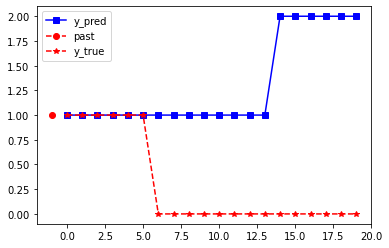

4788082


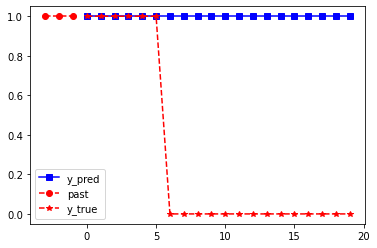

4788082


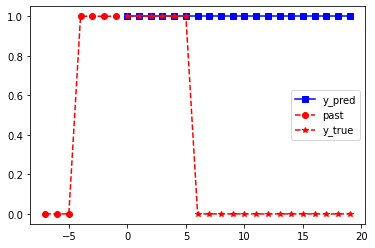

4788082


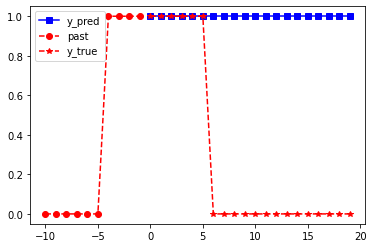

4788082


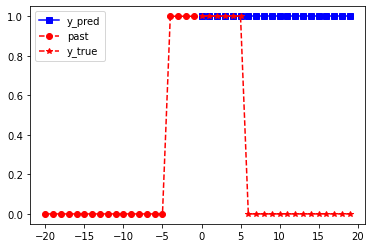

In [78]:
for p in [1, 5, 10, 20]:
    p_df, f_df, y_true, y_pred = predict_single_event(model, train_df, p, 20, start_index=4788082)
    plot_true_pred(y_true, y_pred, p_df, f_df)

## Predicting on un-trained, test data

799594


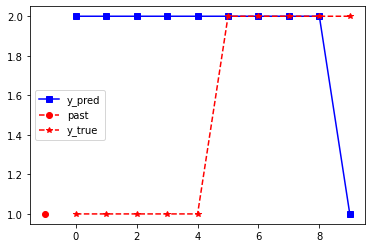

1007391


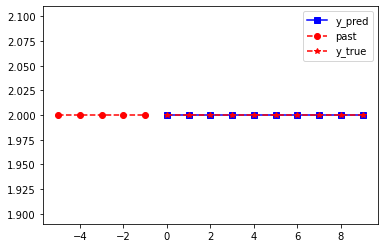

587462


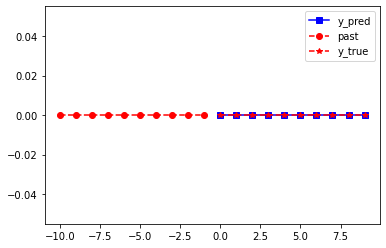

3591258


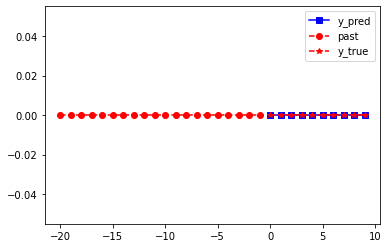

In [92]:
# 406302, 502128, range around 1202521, 862323 good smaple
for p in [1, 5, 10, 20]:
    p_df, f_df, y_true, y_pred = predict_single_event(model, test_df, p, 10, start_index=None)
    # print(y_true)
    plot_true_pred(y_true, y_pred, p_df, f_df)

In [ ]:
clean_test_df = df[(df['transit_date'] >= test_dates[0]) & (df['transit_date'] < test_dates[1])]

In [ ]:
# Pick a random trip and date
random_state = 102
trip_id = clean_test_df.sample(1, random_state=random_state).trip_id.values[0]
transit_date = clean_test_df[clean_test_df['trip_id'] == trip_id].sample(1, random_state=random_state).transit_date.tolist()[0]
tdf = clean_test_df[(clean_test_df['transit_date'] == transit_date) & (clean_test_df['trip_id'] == trip_id)]
tdf = tdf.sort_values('arrival_time').sort_index()
tdf = prepare_clean_data_for_inference(tdf, encoder_dict, num_scaler)

In [ ]:
past_df = tdf[:5]
forecast_df = tdf[5:]
predictions = generate_stop_sequence_prediction(model, past_df, forecast_df)
plot_true_pred(forecast_df.y_class.tolist(), predictions, past_df)

In [ ]:
# Prediction/Generation
# https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/